# 추론 통계

In [1]:
from pathlib import Path
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform
import matplotlib
import seaborn as sns

import scipy as sp
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    
matplotlib.rcParams['axes.unicode_minus'] = False

# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한 
%precision 3
# DataFrame의 출력을 소수점 이하 3자리로 제한 
pd.set_option('precision', 3)

## 추정

### 모멘트 방법을 이용한 베타 분포 확인

/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


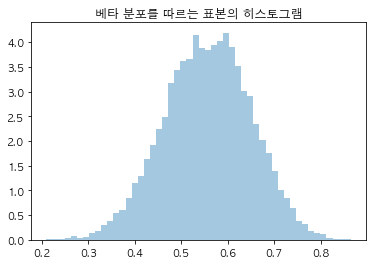

In [2]:
np.random.seed(42)
#베타 분포를 따르는 데이터 생성 - 모수는 15 와 12
x = sp.stats.beta(15, 12).rvs(10000)

sns.distplot(x, kde=False, norm_hist=True)
plt.title("베타 분포를 따르는 표본의 히스토그램")
plt.show()

In [3]:
# 모수 확인
def estimate_beta(x):
    x_bar = x.mean()
    s2 = x.var()
    a = x_bar * (x_bar * (1 - x_bar) / s2 - 1)
    b = (1 - x_bar) * (x_bar * (1 - x_bar) / s2 - 1)
    return a, b


params = estimate_beta(x)
print(params)

(15.356719615033896, 12.223836892489079)


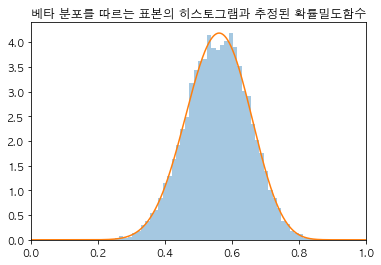

In [4]:
xx = np.linspace(0, 1, 1000)
sns.distplot(x, kde=False, norm_hist=True)
plt.plot(xx, sp.stats.beta(params[0], params[1]).pdf(xx))
plt.xlim(0, 1)
plt.title("베타 분포를 따르는 표본의 히스토그램과 추정된 확률밀도함수")
plt.show()

/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


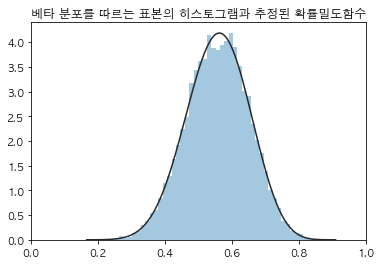

In [5]:
#distplot 에는 모수 추정 기능이 있음 - fit 매개변수 이용
sns.distplot(x, kde=False, norm_hist=True, fit=sp.stats.beta)
plt.xlim(0, 1)
plt.title("베타 분포를 따르는 표본의 히스토그램과 추정된 확률밀도함수")
plt.show()

### 가능도 함수를 이용한 정규 분포

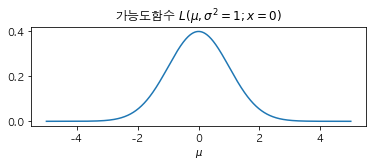

In [6]:
def likelihood_mu(mu):
    return sp.stats.norm(loc=mu).pdf(0)

mus = np.linspace(-5, 5, 1000)
likelihood_mu = [likelihood_mu(m) for m in mus]

plt.subplot(211)
plt.plot(mus, likelihood_mu)
plt.title("가능도함수 $L(\mu, \sigma^2=1; x=0)$")
plt.xlabel("$\mu$")
plt.show()

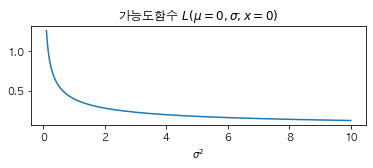

In [7]:
def likelihood_sigma2(sigma2):
    return sp.stats.norm(scale=np.sqrt(sigma2)).pdf(0)

sigma2s = np.linspace(0.1, 10, 1000)
likelihood_sigma2 = [likelihood_sigma2(s) for s in sigma2s]

plt.subplot(212)
plt.plot(sigma2s, likelihood_sigma2)
plt.title("가능도함수 $L(\mu=0, \sigma; x=0)$")
plt.xlabel("$\sigma^2$")
plt.show()

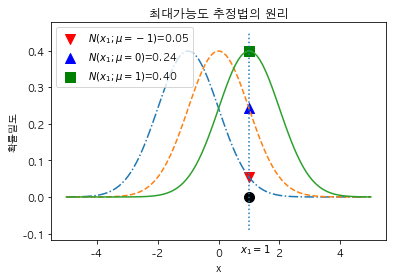

In [8]:
x = np.linspace(-5, 5, 100)

p1 = sp.stats.norm(loc=-1).pdf(1)
p2 = sp.stats.norm(loc=0).pdf(1)
p3 = sp.stats.norm(loc=1).pdf(1)

plt.scatter(1, p1, s=100, c='r', marker='v', 
         label=r"$N(x_1;\mu=-1)$={:.2f}".format(np.round(p1, 2)))
plt.scatter(1, p2, s=100, c='b', marker='^', 
         label=r"$N(x_1;\mu=0)$={:.2f}".format(np.round(p2, 2)))
plt.scatter(1, p3, s=100, c='g', marker='s', 
         label=r"$N(x_1;\mu=1)$={:.2f}".format(np.round(p3, 2)))

plt.plot(x, sp.stats.norm(loc=-1).pdf(x), ls="-.")
plt.plot(x, sp.stats.norm(loc=0).pdf(x), ls="--")
plt.plot(x, sp.stats.norm(loc=1).pdf(x), ls="-")
plt.scatter(1, 0, s=100, c='k')
plt.vlines(1, -0.09, 0.45, linestyle=":")
plt.text(1-0.3, -0.15, "$x_1=1$")
plt.xlabel("x")
plt.ylabel("확률밀도")
plt.legend()
plt.title("최대가능도 추정법의 원리")
plt.show()

### 기댓값이 2 분산이 4인 정규분포에서 나온 정규분포의 기댓값을 베이즈 추정법으로 추정한 결과

0차 추정: 1.98
1차 추정: 2.07
2차 추정: 2.05
3차 추정: 2.03


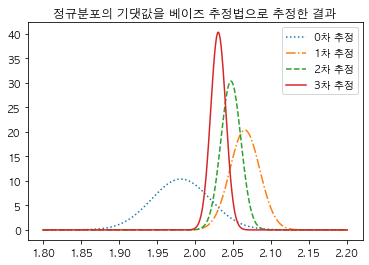

In [9]:
mu, sigma2 = 2, 4
mu0, sigma20 = 0, 1
xx = np.linspace(1.8, 2.2, 1000)
np.random.seed(1)
N = 100
ls = [":", "-.", "--", "-"]
for i in range(4):
    x = sp.stats.norm(mu).rvs(N)
    mu0 = sigma2/(N*sigma20 + sigma2) * mu0 + \
        (N*sigma20)/(N*sigma20 + sigma2)*x.mean()
    sigma20 = 1/(1/sigma20 + N/sigma2)
    plt.plot(xx, sp.stats.norm(mu0, sigma20).pdf(xx), ls=ls[i], label="{}차 추정".format(i))
    print("{}차 추정: {:4.2f}".format(i, mu0))
plt.legend()
plt.title("정규분포의 기댓값을 베이즈 추정법으로 추정한 결과")
plt.show()

## 추론 통계

### 통계적 유의성

Observed difference: 0.0368%


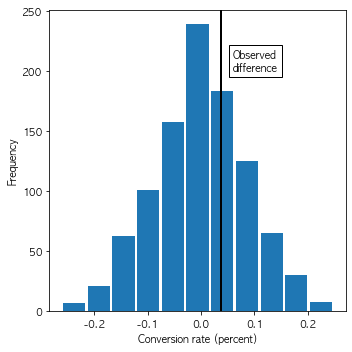

In [10]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

#차이의 히스토그램
random.seed(1)

obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### p-value

In [11]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

0.332
p-value for single sided test: 0.3498


### 신뢰 구간

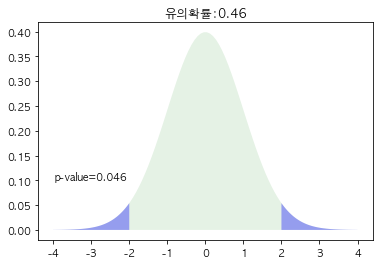

In [12]:
xx1 = np.linspace(-4, 4, 100)
xx2 = np.linspace(-4, -2, 100)
xx3 = np.linspace(2, 4, 100)

plt.fill_between(xx1, sp.stats.norm.pdf(xx1), facecolor='green', alpha=0.1)
plt.fill_between(xx2, sp.stats.norm.pdf(xx2), facecolor='blue', alpha=0.35)
plt.fill_between(xx3, sp.stats.norm.pdf(xx3), facecolor='blue', alpha=0.35)
plt.text(-3, 0.1, "p-value=%5.3f" % (2*sp.stats.norm.cdf(-2)), horizontalalignment='center')
plt.title("유의확률:0.46")

plt.show()

### 동전을 던졌을 때 15번 던졌을 때 12번 나온 경우에 대한 검정

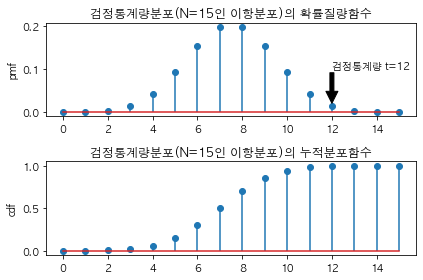

In [13]:
#확률 질량 함수 와 누적 분포 함수
N = 15
mu = 0.5
rv = sp.stats.binom(N, mu)

xx = np.arange(N + 1)

plt.subplot(211)
plt.stem(xx, rv.pmf(xx))
plt.ylabel("pmf")
plt.title("검정통계량분포(N=15인 이항분포)의 확률질량함수")
black = {"facecolor": "black"}
plt.annotate('검정통계량 t=12', xy=(12, 0.02), xytext=(12, 0.1), arrowprops=black)

plt.subplot(212)
plt.stem(xx, rv.cdf(xx))
plt.ylabel("cdf")
plt.title("검정통계량분포(N=15인 이항분포)의 누적분포함수")

plt.tight_layout()
plt.show()

In [14]:
#양측 검정의 유의 확률
2 * (1 - rv.cdf(12 - 1))

0.03515625

In [15]:
#단측 검정의 유의 확률
1 - rv.cdf(12 - 1)

0.017578125

## 검정

### 이항 검정

In [16]:
#베르누이 확률 변수의 시뮬레이션을 통한 이항검정 
#데이터 개수가 10일 때 1이 나온 횟수는 7
N = 10
mu_0 = 0.5
np.random.seed(0)
x = sp.stats.bernoulli(mu_0).rvs(N)
n = np.count_nonzero(x)
print(n)

#유의확률
sp.stats.binom_test(n, N)

7


0.34375

### 베르누이 검정

In [17]:
#게임에서 내가 이길 확률은 0.3인 경우 100번 했을 때 30번 이길 유의확률은?
#이것이 가능한 것인지 유의수준 5%로 검정
r = 1-sp.stats.binom(100, 0.3).cdf(30 - 1)
if r > 0.05:
    print("p-value가 0.05보다 크므로 정상적인 상황입니다.")
else:
    print("p-value가 0.05보다 작으므로 발생할 가능성이 낮은 상황입니다.")
    
#게임에서 내가 이길 확률은 0.3인 경우 100번 했을 때 60번 이길 유의확률은?
#이것이 가능한 것인지 유의수준 5%로 검정
r = 1-sp.stats.binom(100, 0.3).cdf(60 - 1)
if r > 0.05:
    print("p-value가 0.05보다 크므로 정상적인 상황입니다.")
else:
    print("p-value가 0.05보다 작으므로 발생할 가능성이 낮은 상황입니다.")

p-value가 0.05보다 크므로 정상적인 상황입니다.
p-value가 0.05보다 작으므로 발생할 가능성이 낮은 상황입니다.


In [18]:
tips = sns.load_dataset("tips")
print(tips.head())

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4


In [19]:
female = tips[tips['sex'] == 'Female']
fem_cnt = female['sex'].count()
non_smoke_cnt = female[female['smoker'] =='No'].count()
r = 1-sp.stats.binom(fem_cnt, 0.5).cdf(non_smoke_cnt[0] - 1)
print(r)
if r > 0.1:
    print("여자의 비흡연율이 흡연율보다 높다고 할 수 없다.")
else:
    print("여자의 비흡연율이 흡연율보다 높다고 할 수 있다.")

0.015709055116923
여자의 비흡연율이 흡연율보다 높다고 할 수 있다.


In [20]:
female = tips[(tips['sex'] == 'Female') & (tips['time'] == 'Dinner')]
fem_cnt = female['time'].count()

non_smoke_cnt = female[female['smoker'] =='No'].count()

r = 1-sp.stats.binom(fem_cnt, 0.5).cdf(non_smoke_cnt[0] - 1)
print(r)
if r > 0.1:
    print("저녘에 오는 여자손님의 비흡연율이 흡연율보다 높다고 할 수 없다.")
else:
    print("저녘에 오는 여자손님의 비흡연율이 흡연율보다 높다고 할 수 있다.")

0.24422783468994602
저녘에 오는 여자손님의 비흡연율이 흡연율보다 높다고 할 수 없다.


### 단일 표본 t-검정

In [21]:
#데이터 개수  N=10 , 실제 모수  μ0=0 인 경우 대해 단일표본 t검정 명령
N = 10
mu_0 = 0
np.random.seed(0)
#평균이 0이라고 설정하고 데이터 개수는 10인 모델 생성 
x = sp.stats.norm(mu_0).rvs(N)
sp.stats.ttest_1samp(x, popmean=0)

Ttest_1sampResult(statistic=2.28943967238967, pvalue=0.04781846490857058)

In [22]:
#데이터 개수  N=100 , 실제 모수  μ0=0 인 경우 대해 단일표본 t검정 명령
N = 100
mu_0 = 0
np.random.seed(0)
x = sp.stats.norm(mu_0).rvs(N)
sp.stats.ttest_1samp(x, popmean=0)

Ttest_1sampResult(statistic=0.5904283402851698, pvalue=0.5562489158694675)

In [23]:
items = pd.read_csv('./data/tdata.csv', encoding='ms949')
#평균이 75라고 할 수 있는지 유의수준 5%로 검정
result = sp.stats.ttest_1samp(items['성적'], popmean=75).pvalue
print("유의확률:", result)
if result >= 0.05:
    print("평균은 75라고 할 수 있습니다.")
else:
    print("평균은 75라고 할 수 없습니다.")

유의확률: 0.5079049500571382
평균은 75라고 할 수 있습니다.


### 독립 표본 t 검정

/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


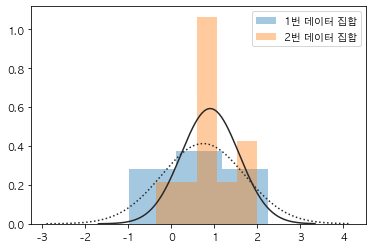

In [24]:
N_1 = 10
mu_1 = 0
sigma_1 = 1

N_2 = 10
mu_2 = 0.5
sigma_2 = 1

np.random.seed(0)
x1 = sp.stats.norm(mu_1, sigma_1).rvs(N_1)
x2 = sp.stats.norm(mu_2, sigma_2).rvs(N_2)

ax = sns.distplot(x1, kde=False, fit=sp.stats.norm, label="1번 데이터 집합")
ax = sns.distplot(x2, kde=False, fit=sp.stats.norm, label="2번 데이터 집합")
ax.lines[0].set_linestyle(":")
plt.legend()
plt.show()

In [25]:
print(np.mean(x1), np.mean(x2))
print(sp.stats.ttest_ind(x1, x2, equal_var=False))

0.7380231707288347 0.9006460151624349
Ttest_indResult(statistic=-0.4139968526988655, pvalue=0.6843504889824326)


In [26]:
N_1 = 50
mu_1 = 0
sigma_1 = 1

N_2 = 100
mu_2 = 0.5
sigma_2 = 1

np.random.seed(0)
x1 = sp.stats.norm(mu_1, sigma_1).rvs(N_1)
x2 = sp.stats.norm(mu_2, sigma_2).rvs(N_2)
sp.stats.ttest_ind(x1, x2, equal_var=True)

Ttest_indResult(statistic=-2.6826951236616963, pvalue=0.008133970915722658)

/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


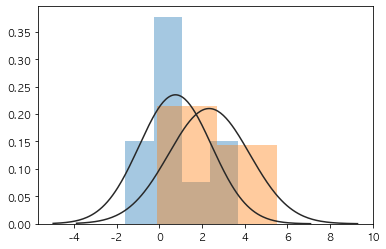

2가지 약의 평균 수면 증가시간은 같다.


In [27]:
x1 = np.array([0.7,-1.6,-0.2,-1.2,-0.1,3.4,3.7,0.8,0.0,2.0]);
x2 = np.array([1.9,0.8,1.1,0.1,-0.1,4.4,5.5,1.6,4.6,3.4]);
sns.distplot(x1, kde=False, fit=sp.stats.norm)
sns.distplot(x2, kde=False, fit=sp.stats.norm)
plt.show()
r = sp.stats.ttest_ind(x1, x2, equal_var=True)
if r.pvalue >= 0.05:
    print("2가지 약의 평균 수면 증가시간은 같다.")
else:
    print("2가지 약의 평균 수면 증가시간은 다르다.")

1반의 평균 성적: 74.16666666666667
2반의 평균 성적: 69.28571428571429


/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


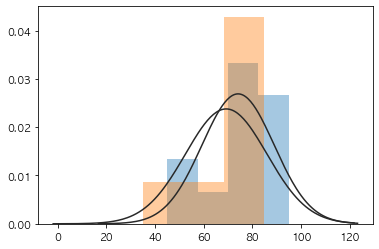

Ttest_indResult(statistic=0.623010926550264, pvalue=0.5415458608473267)
1반과 2반의 성적은 같다.


In [28]:
x1 = np.array([80,75,85,50,60,75,45,70,90,95,85,80])
x2 = np.array([80,85,70,80,35,55,80]);

print("1반의 평균 성적:", np.mean(x1))
print("2반의 평균 성적:", np.mean(x2))

sns.distplot(x1, kde=False, fit=sp.stats.norm)
sns.distplot(x2, kde=False, fit=sp.stats.norm)
plt.show()
r = sp.stats.ttest_ind(x1, x2, equal_var=True)
print(r)
if r.pvalue >= 0.05:
    print("1반과 2반의 성적은 같다.")
else:
    print("1반과 2반의 성적은 다르다.")


In [30]:
#Page A 의 평균 세션시간이 Page B의 평균 세션시간 보다 작다는 대립 가설을 설정 
## t-Tests
session_times = pd.read_csv('./data/web_page_data.csv')
session_times.Time = 100 * session_times.Time

res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

#Page A 의 평균 세션시간이 Page B의 평균 세션시간 보다 작다는 대립 가설을 설정 
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
#유의 확률이 0.1408
print(f'p-value: {pvalue:.4f}')

p-value for single sided test: 0.1408
p-value: 0.1408


### 대응 표본 t-검정

/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


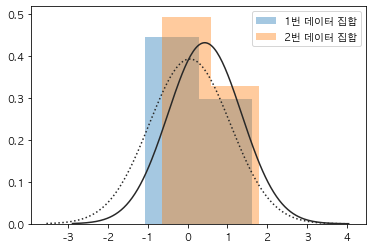

Ttest_relResult(statistic=-5.662482449248929, pvalue=0.0047953456833781305)


In [31]:
N = 5
mu_1 = 0
mu_2 = 0.4
np.random.seed(1)
x1 = sp.stats.norm(mu_1).rvs(N)
x2 = x1 + sp.stats.norm(mu_2, 0.1).rvs(N)

ax = sns.distplot(x1, kde=False, fit=sp.stats.norm, label="1번 데이터 집합")
ax = sns.distplot(x2, kde=False, fit=sp.stats.norm, label="2번 데이터 집합")
ax.lines[0].set_linestyle(":")
plt.legend()
plt.show()
print(sp.stats.ttest_rel(x1, x2))

In [32]:
x1 = np.array([0.7,-1.6,-0.2,-1.2,-0.1,3.4,3.7,0.8,0.0,2.0]);
x2 = np.array([1.9,0.8,1.1,0.1,-0.1,4.4,5.5,1.6,4.6,3.4]);
r = sp.stats.ttest_rel(x1, x2)
print(x1.mean())
print(x2.mean())
if r.pvalue >= 0.05:
    print("2가지 약의 평균 수면 증가시간은 같다.")
else:
    print("2가지 약의 평균 수면 증가시간은 다르다.")

0.75
2.3299999999999996
2가지 약의 평균 수면 증가시간은 다르다.


### 윌콕슨의 부호 순위 검정

In [82]:
training_rel = pd.read_csv('./data/training_rel.csv')
toy_df = training_rel[:6].copy()
toy_df

,전,후
0,59,41
1,52,63
2,55,68
3,61,59
4,59,84
5,45,37


In [83]:
diff = toy_df['후'] - toy_df['전']
toy_df['차'] = diff
toy_df

,전,후,차
0,59,41,-18
1,52,63,11
2,55,68,13
3,61,59,-2
4,59,84,25
5,45,37,-8


In [84]:
rank = stats.rankdata(abs(diff)).astype(int)
toy_df['순위'] = rank
toy_df

,전,후,차,순위
0,59,41,-18,5
1,52,63,11,3
2,55,68,13,4
3,61,59,-2,1
4,59,84,25,6
5,45,37,-8,2


In [85]:
r_minus = np.sum((diff < 0) * rank)
r_plus = np.sum((diff > 0) * rank)

r_minus, r_plus

(8, 13)

In [87]:
toy_df['후'] = toy_df['전'] + np.arange(1, 7)
diff = toy_df['후'] - toy_df['전']
rank = stats.rankdata(abs(diff)).astype(int)
toy_df['차'] = diff
toy_df['순위'] = rank
print(toy_df)

r_minus = np.sum((diff < 0) * rank)
r_plus = np.sum((diff > 0) * rank)

r_minus, r_plus

    전   후  차  순위
0  59  60  1   1
1  52  54  2   2
2  55  58  3   3
3  61  65  4   4
4  59  64  5   5
5  45  51  6   6


(0, 21)

In [88]:
toy_df['후'] = toy_df['전'] + [1, -2, -3, 4, 5, -6]
diff = toy_df['후'] - toy_df['전']
rank = stats.rankdata(abs(diff)).astype(int)
toy_df['차'] = diff
toy_df['순위'] = rank
print(toy_df)
r_minus = np.sum((diff < 0) * rank)
r_plus = np.sum((diff > 0) * rank)

r_minus, r_plus

    전   후  차  순위
0  59  60  1   1
1  52  50 -2   2
2  55  52 -3   3
3  61  65  4   4
4  59  64  5   5
5  45  39 -6   6


(11, 10)

In [89]:
T, p = stats.wilcoxon(training_rel['전'], training_rel['후'])
p

0.03623390197753906

### 만 • 위트니의 U 검정

In [90]:
training_ind = pd.read_csv('./data/training_ind.csv')
toy_df = training_ind[:5].copy()
toy_df

,A,B
0,47,49
1,50,52
2,37,54
3,60,48
4,39,51


In [91]:
rank = stats.rankdata(np.concatenate([toy_df['A'],
                                      toy_df['B']]))
rank_df = pd.DataFrame({'A': rank[:5],
                        'B': rank[5:10]}).astype(int)
rank_df

,A,B
0,3,5
1,6,8
2,1,9
3,10,4
4,2,7


In [92]:
n1 = len(rank_df['A'])
u = rank_df['A'].sum() - (n1*(n1+1))/2
u

7.0

In [93]:
u, p = stats.mannwhitneyu(training_ind['A'], training_ind['B'],
                          alternative='two-sided')
p

0.05948611166127324

## 국가별 음주 데이터 분석

### 탐색 데이터 기초 정보 확인

In [33]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = './data/drinks.csv'
drinks = pd.read_csv(file_path) # read_csv 함수로 데이터를 Dataframe 형태로 불러옵니다.
drinks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       193 non-null    object 
 1   beer_servings                 193 non-null    int64  
 2   spirit_servings               193 non-null    int64  
 3   wine_servings                 193 non-null    int64  
 4   total_litres_of_pure_alcohol  193 non-null    float64
 5   continent                     170 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ KB


In [34]:
#수치 정보의 요약 통계량 확인
drinks.describe()

,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
count,193.000,193.000,193.000,193.000
mean,106.161,80.995,49.451,4.717
std,101.143,88.284,79.698,3.773
min,0.000,0.000,0.000,0.000
25%,20.000,4.000,1.000,1.300
50%,76.000,56.000,8.000,4.200
75%,188.000,128.000,59.000,7.200
max,376.000,438.000,370.000,14.400


### 상관 분석

In [35]:
# 'beer_servings', 'wine_servings' 두 피처간의 상관계수를 계산합니다.
# pearson은 상관계수를 구하는 계산 방법 중 하나를 의미하며, 가장 널리 쓰이는 방법입니다.
corr = drinks[['beer_servings', 'wine_servings']].corr(method = 'pearson')
print(corr)

               beer_servings  wine_servings
beer_servings          1.000          0.527
wine_servings          0.527          1.000


In [36]:
# 피처간의 상관계수 행렬을 구합니다.
cols = ['beer_servings', 'spirit_servings', 'wine_servings', 'total_litres_of_pure_alcohol']
corr = drinks[cols].corr(method = 'pearson')
print(corr)

                              beer_servings  spirit_servings  wine_servings  \
beer_servings                         1.000            0.459          0.527   
spirit_servings                       0.459            1.000          0.195   
wine_servings                         0.527            0.195          1.000   
total_litres_of_pure_alcohol          0.836            0.655          0.668   

                              total_litres_of_pure_alcohol  
beer_servings                                        0.836  
spirit_servings                                      0.655  
wine_servings                                        0.668  
total_litres_of_pure_alcohol                         1.000  


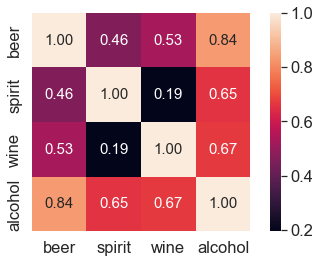

In [37]:
import seaborn as sns

# corr 행렬 히트맵을 시각화합니다.
cols_view = ['beer', 'spirit', 'wine', 'alcohol'] # 그래프 출력을 위한 cols 이름을 축약합니다.
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols_view,
            xticklabels=cols_view)

plt.tight_layout()
plt.show()

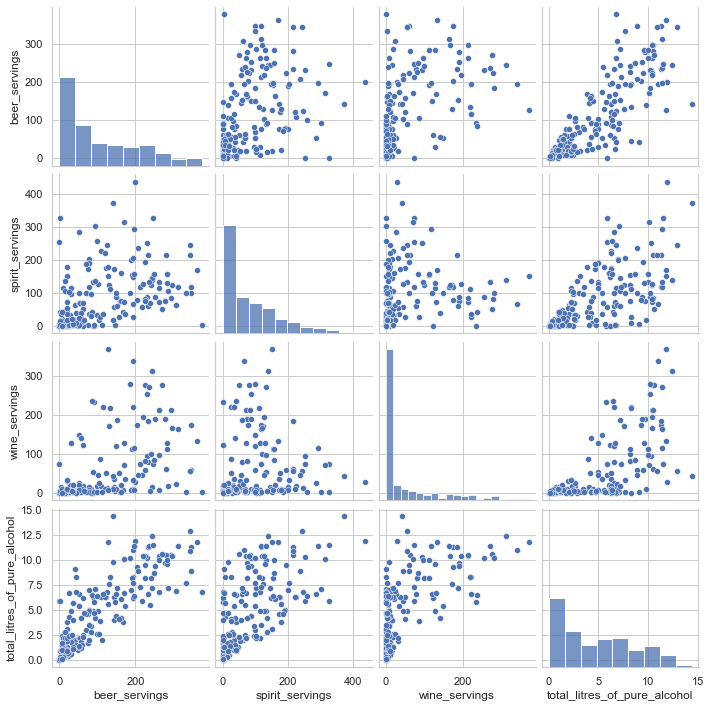

In [38]:
# 시각화 라이브러리를 이용한 피처간의 scatter plot을 출력합니다.
sns.set(style='whitegrid', context='notebook')
sns.pairplot(drinks[['beer_servings', 'spirit_servings', 
                     'wine_servings', 'total_litres_of_pure_alcohol']], height=2.5)
plt.show()

### 개념적 탐색

In [39]:
#결측치 처리 - 결측치에 특정 값 입력
print(drinks.isnull().sum())
print("------------------------------------")
print(drinks.dtypes)
print("------------------------------------")
print(drinks.head(10))

# 결측데이터를 처리합니다 : 기타 대륙으로 통합 -> 'OT'
drinks['continent'] = drinks['continent'].fillna('OT')
print("------------------------------------")
drinks.head(10)

country                          0
beer_servings                    0
spirit_servings                  0
wine_servings                    0
total_litres_of_pure_alcohol     0
continent                       23
dtype: int64
------------------------------------
country                          object
beer_servings                     int64
spirit_servings                   int64
wine_servings                     int64
total_litres_of_pure_alcohol    float64
continent                        object
dtype: object
------------------------------------
             country  beer_servings  spirit_servings  wine_servings  \
0        Afghanistan              0                0              0   
1            Albania             89              132             54   
2            Algeria             25                0             14   
3            Andorra            245              138            312   
4             Angola            217               57             45   
5  Antigua & Barbuda   

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,continent
0,Afghanistan,0,0,0,0.0,AS
1,Albania,89,132,54,4.9,EU
2,Algeria,25,0,14,0.7,AF
3,Andorra,245,138,312,12.4,EU
4,Angola,217,57,45,5.9,AF
5,Antigua & Barbuda,102,128,45,4.9,OT
6,Argentina,193,25,221,8.3,SA
7,Armenia,21,179,11,3.8,EU
8,Australia,261,72,212,10.4,OC
9,Austria,279,75,191,9.7,EU


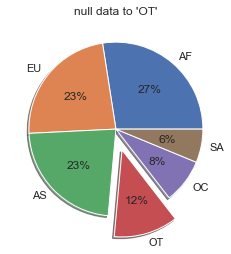

In [40]:
# 대륙별 데이터 비교하기
labels = drinks['continent'].value_counts().index.tolist()
fracs1 = drinks['continent'].value_counts().values.tolist()
explode = (0, 0, 0, 0.25, 0, 0)

plt.pie(fracs1, explode=explode, labels=labels, autopct='%.0f%%', shadow=True)
plt.title('null data to \'OT\'')
plt.show()

In [41]:
# 대륙별 spirit_servings의 평균, 최소, 최대, 합계를 계산합니다.
result = drinks.groupby('continent').spirit_servings.agg(['mean', 'min', 'max', 'sum'])
result

,mean,min,max,sum
continent,,,,
AF,16.340,0,152,866
AS,60.841,0,326,2677
EU,132.556,0,373,5965
OC,58.438,0,254,935
OT,165.739,68,438,3812
SA,114.750,25,302,1377


In [42]:
# 전체 평균보다 많은 알코올을 섭취하는 대륙을 구합니다.
total_mean = drinks.total_litres_of_pure_alcohol.mean()
continent_mean = drinks.groupby('continent')['total_litres_of_pure_alcohol'].mean()
continent_over_mean = continent_mean[continent_mean >= total_mean]
print(continent_over_mean)

continent
EU    8.618
OT    5.996
SA    6.308
Name: total_litres_of_pure_alcohol, dtype: float64


In [43]:
# 평균 beer_servings이 가장 높은 대륙을 구합니다.
beer_continent = drinks.groupby('continent').beer_servings.mean().idxmax()
print(beer_continent)

EU


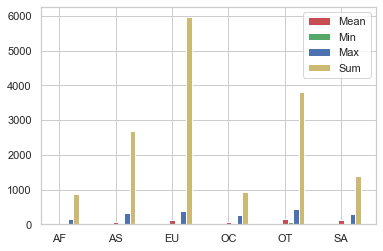

In [44]:
# 대륙별 spirit_servings의 평균, 최소, 최대, 합계를 시각화합니다.
n_groups = len(result.index)
means = result['mean'].tolist()
mins = result['min'].tolist()
maxs = result['max'].tolist()
sums = result['sum'].tolist()
 
index = np.arange(n_groups)
bar_width = 0.1
 
rects1 = plt.bar(index, means, bar_width,
                 color='r',
                 label='Mean')
 
rects2 = plt.bar(index + bar_width, mins, bar_width,
                 color='g',
                 label='Min')

rects3 = plt.bar(index + bar_width * 2, maxs, bar_width,
                 color='b',
                 label='Max')
 
rects4 = plt.bar(index + bar_width * 3, sums, bar_width,
                 color='y',
                 label='Sum')

plt.xticks(index, result.index.tolist())
plt.legend()
plt.show()

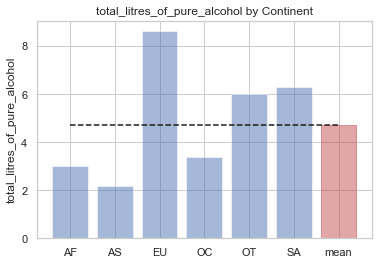

In [45]:
# 대륙별 total_litres_of_pure_alcohol을 시각화합니다.
continents = continent_mean.index.tolist()
continents.append('mean')
x_pos = np.arange(len(continents))
alcohol = continent_mean.tolist()
alcohol.append(total_mean)
 
bar_list = plt.bar(x_pos, alcohol, align='center', alpha=0.5)
bar_list[len(continents) - 1].set_color('r')
plt.plot([0., 6], [total_mean, total_mean], "k--")
plt.xticks(x_pos, continents)

plt.ylabel('total_litres_of_pure_alcohol')
plt.title('total_litres_of_pure_alcohol by Continent')

plt.show()

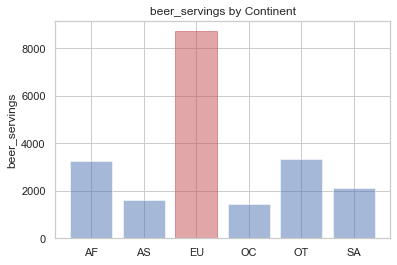

In [46]:
# 대륙별 beer_servings을 시각화합니다.
beer_group = drinks.groupby('continent')['beer_servings'].sum()
continents = beer_group.index.tolist()
y_pos = np.arange(len(continents))
alcohol = beer_group.tolist()
 
bar_list = plt.bar(y_pos, alcohol, align='center', alpha=0.5)
bar_list[continents.index("EU")].set_color('r')
plt.xticks(y_pos, continents)
plt.ylabel('beer_servings')
plt.title('beer_servings by Continent')
 
plt.show()

### t-test 검정

In [47]:
#아프리카 와 유럽 대륙의 맥주 소비량이 다른지 검점
# 아프리카와 유럽간의 맥주 소비량 차이를 검정합니다.
africa = drinks.loc[drinks['continent']=='AF']
europe = drinks.loc[drinks['continent']=='EU']

from scipy import stats
#분산이 같다고 가정
tTestResult = stats.ttest_ind(africa['beer_servings'], europe['beer_servings'])
#분산이 다르다고 가정
tTestResultDiffVar = stats.ttest_ind(africa['beer_servings'], europe['beer_servings'], equal_var=False)

print(tTestResult)
print(tTestResultDiffVar)

Ttest_indResult(statistic=-7.267986335644365, pvalue=9.719556422442453e-11)
Ttest_indResult(statistic=-7.143520192189803, pvalue=2.9837787864303205e-10)


### 한국인은 술을 독하게 마시는가?

          country  alcohol_rate
63         Gambia         0.267
153  Sierra Leone         0.223
124       Nigeria         0.186
179        Uganda         0.154
142        Rwanda         0.151


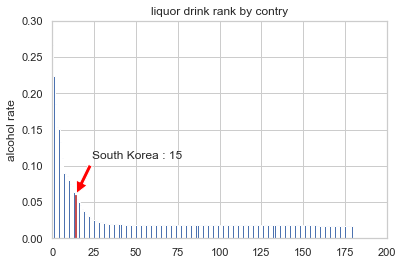

In [48]:
# total_servings 피처를 생성합니다.
drinks['total_servings'] = drinks['beer_servings'] + drinks['wine_servings'] + drinks['spirit_servings']

# 술 소비량 대비 알콜 비율 피처를 생성합니다.
drinks['alcohol_rate'] = drinks['total_litres_of_pure_alcohol'] / drinks['total_servings']
drinks['alcohol_rate'] = drinks['alcohol_rate'].fillna(0)

# 순위 정보를 생성합니다.
country_with_rank = drinks[['country', 'alcohol_rate']]
country_with_rank = country_with_rank.sort_values(by=['alcohol_rate'], ascending=0)
print(country_with_rank.head(5))

# 국가별 순위 정보를 그래프로 시각화합니다.
country_list = country_with_rank.country.tolist()
x_pos = np.arange(len(country_list))
rank = country_with_rank.alcohol_rate.tolist()
 
bar_list = plt.bar(x_pos, rank)
bar_list[country_list.index("South Korea")].set_color('r')
plt.ylabel('alcohol rate')
plt.title('liquor drink rank by contry')
plt.axis([0, 200, 0, 0.3])

korea_rank = country_list.index("South Korea")
korea_alc_rate = country_with_rank[country_with_rank['country'] == 'South Korea']['alcohol_rate'].values[0]
plt.annotate('South Korea : ' + str(korea_rank + 1), 
             xy=(korea_rank, korea_alc_rate), 
             xytext=(korea_rank + 10, korea_alc_rate + 0.05),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

In [49]:
# total_servings 피처를 생성합니다.
drinks['total_servings'] = drinks['beer_servings'] + drinks['wine_servings'] + drinks['spirit_servings']

# 술 소비량 대비 알콜 비율 피처를 생성합니다.
drinks['alcohol_rate'] = drinks['total_litres_of_pure_alcohol'] / drinks['total_servings']
drinks['alcohol_rate'] = drinks['alcohol_rate'].fillna(0)

print(drinks['alcohol_rate'].mean() + drinks['alcohol_rate'].std() * 1.96)

0.09172202496173912


### 등분산 검정

/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adam/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/adam/opt/anaconda3/lib/python3.9/site-packages/IPython

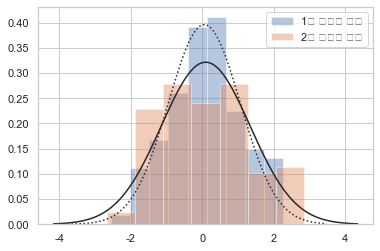

In [50]:
N1 = 100
N2 = 100
sigma_1 = 1
sigma_2 = 1.2
np.random.seed(0)
x1 = sp.stats.norm(0, sigma_1).rvs(N1)
x2 = sp.stats.norm(0, sigma_2).rvs(N2)
ax = sns.distplot(x1, kde=False, fit=sp.stats.norm, label="1번 데이터 집합")
ax = sns.distplot(x2, kde=False, fit=sp.stats.norm, label="2번 데이터 집합")
ax.lines[0].set_linestyle(":")
plt.legend()
plt.show()

In [51]:
#표준편차
print(x1.std(), x2.std())
#유의수준 1% 기준에서 bartlett 명령의 결과는 두 데이터 집합의 분산이 같다고 계산하지만 
#fligner, levene 명령은 두 데이터 집합의 분산이 다르다고 계산
print(sp.stats.bartlett(x1, x2))
print(sp.stats.fligner(x1, x2))
print(sp.stats.levene(x1, x2))

1.0078822447165796 1.2416003969261071
BartlettResult(statistic=4.253473837232266, pvalue=0.039170128783651344)
FlignerResult(statistic=7.224841990409457, pvalue=0.007190150106748367)
LeveneResult(statistic=7.680708947679437, pvalue=0.0061135154970207925)


### 분산 분석

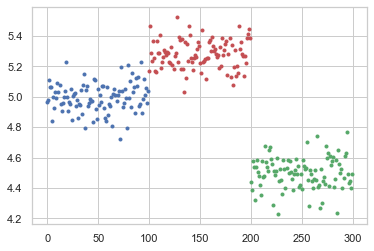

In [52]:
#분산의 중요함 - 평균은 동일하지만 분산이 다름으로 인해서 분포가 달라짐
centers = [5,5.3,4.5]
std = 0.1
colors = 'brg'

data_1 = []
for i in range(3):
    data_1.append(stats.norm(centers[i], std).rvs(100))
    plt.plot(np.arange(len(data_1[i]))+i*len(data_1[0]),data_1[i], '.', color = colors[i])

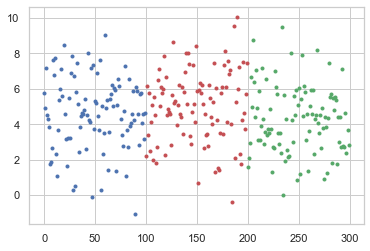

In [53]:
std_2 = 2
data_2 = []
for i in range(3):
    data_2.append(stats.norm(centers[i], std_2).rvs(100))
    plt.plot(np.arange(len(data_1[i]))+i*len(data_2[0]), data_2[i], '.', color = colors[i])

### 일원 분산 분석

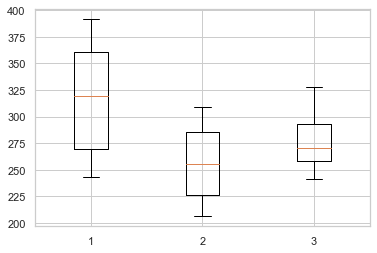

In [54]:
import urllib.request

# url로 데이터 얻어오기
url = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_altman/altman_910.txt'
data = np.genfromtxt(urllib.request.urlopen(url), delimiter=',')

# Sort them into groups, according to column 1
group1 = data[data[:,1]==1,0]
group2 = data[data[:,1]==2,0]
group3 = data[data[:,1]==3,0]

# matplotlib plotting
plot_data = [group1, group2, group3]
ax = plt.boxplot(plot_data)
plt.show()


In [55]:
# Scipy.stats으로 일원분산분석
F_statistic, pVal = stats.f_oneway(group1, group2, group3)

print('Altman 910 데이터의 일원분산분석 결과 : F={0:.1f}, p={1:.5f}'.format(F_statistic, pVal))
if pVal < 0.05:
    print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')
else :
    print('P-value 값이 충분히 작지 않으므로 인해 그룹의 평균값이 통계적으로 유의미하게 차이나지 않습니다.')

Altman 910 데이터의 일원분산분석 결과 : F=3.7, p=0.04359
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


In [56]:
#Statsmodel을 사용한 일원분산분석
from statsmodels.formula.api import ols
# 경고 메세지 무시하기
import warnings
warnings.filterwarnings('ignore')

df = pd.DataFrame(data, columns=['value', 'treatment'])    

# the "C" indicates categorical data
model = ols('value ~ C(treatment)', df).fit()

print(sm.stats.anova_lm(model))

                df     sum_sq   mean_sq      F  PR(>F)
C(treatment)   2.0  15515.766  7757.883  3.711   0.044
Residual      19.0  39716.097  2090.321    NaN     NaN


### 이원분산분석

<AxesSubplot:title={'center':'head_size'}, xlabel='fetus'>

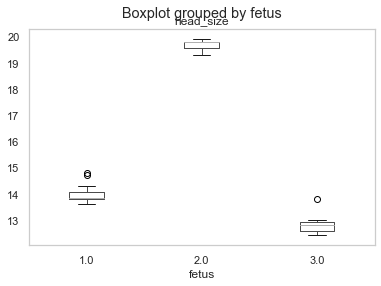

In [57]:
inFile = 'altman_12_6.txt'
url_base = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_altman/'
url = url_base + inFile
data = np.genfromtxt(urllib.request.urlopen(url), delimiter=',')

# Bring them in dataframe-format
df = pd.DataFrame(data, columns=['head_size', 'fetus', 'observer'])
# df.tail()

# 태아별 머리 둘레 plot 만들기
df.boxplot(column = 'head_size', by='fetus' , grid = False)

In [58]:
formula = 'head_size ~ C(fetus) + C(observer) + C(fetus):C(observer)'
lm = ols(formula, df).fit()
print(sm.stats.anova_lm(lm))

                        df   sum_sq  mean_sq         F     PR(>F)
C(fetus)               2.0  324.009  162.004  2113.101  1.051e-27
C(observer)            3.0    1.199    0.400     5.211  6.497e-03
C(fetus):C(observer)   6.0    0.562    0.094     1.222  3.296e-01
Residual              24.0    1.840    0.077       NaN        NaN


     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


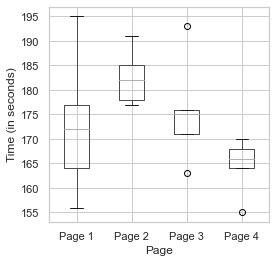

In [60]:
four_sessions = pd.read_csv('./data/four_sessions.csv')
print(four_sessions.head())

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [61]:
print(four_sessions.head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
8.28000000000002
Pr(Prob) 0.082


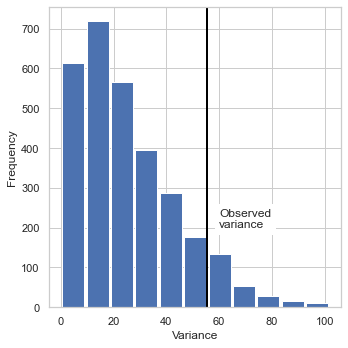

In [62]:
#그룹화
observed_variance = four_sessions.groupby('Page').mean().var()[0]
#그룹별 평균
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
#분산
print('Variance:', observed_variance)

# 랜덤하게 추출해서 분산을 계산해주는 함수
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
#분산 계산    
print(perm_test(four_sessions))

#3000번 수행한 후 평균을 계산
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### F 통계량

In [63]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq  mean_sq     F  PR(>F)
Page       3.0   831.4  277.133  2.74   0.078
Residual  16.0  1618.4  101.150   NaN     NaN


In [64]:
#단측 검정의 결과 유의수준을 0.05를 적용하면 귀무가설 기각 - 분산이 서로 다름 
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


### 카이제곱 검정

#### 순열검정을 이용한 p value

In [66]:
click_rate = pd.read_csv('./data/click_rates.csv')
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988
Observed chi2: 1.6659
Resampled p-value: 0.4820


#### 카이 제곱 분포

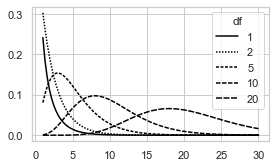

In [67]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

In [68]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


In [69]:
N = 60
K = 6
theta_0 = np.ones(K)/K
np.random.seed(0)
x = np.random.choice(K, N, p=theta_0)
print(x)
n = np.bincount(x, minlength=K)
print(n)
print(sp.stats.chisquare(n))

[3 4 3 3 2 3 2 5 5 2 4 3 3 5 0 0 0 4 4 5 5 4 2 4 0 3 0 5 3 2 1 4 2 3 0 3 3
 3 5 4 2 2 4 0 4 4 1 0 1 2 3 2 5 0 1 0 3 1 2 1]
[10  6 11 14 11  8]
Power_divergenceResult(statistic=3.8000000000000003, pvalue=0.5785552914362737)


In [70]:
#5가지 음료에 대한 선호도를 조사한 후 카이검정 실시
#카이 제곱 검정(유의 확률 0.05)
n = [41,30,51,71,61]
print(sp.stats.chisquare(n))

Power_divergenceResult(statistic=20.488188976377952, pvalue=0.00039991784008227264)


In [71]:
obs = np.array([[5, 15], [10, 20]])
result = sp.stats.chi2_contingency(obs)
print(result)

(0.0992063492063492, 0.7527841326498471, 1, array([[ 6., 14.],
       [ 9., 21.]]))


In [72]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'fisher: {pvalue:.4f}')

Observed chi2: 1.6659
fisher: 0.4348


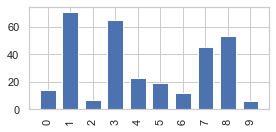

Power_divergenceResult(statistic=174.36507936507934, pvalue=7.59531890073772e-33)


In [73]:
data = [14, 71, 7, 65, 23, 19, 12, 45, 53, 6]
df = pd.DataFrame({'idx':list(range(0,10)), 'data':data})

plt.figure(figsize = (4,2))   
plt.bar(df.index, df['data'], width=0.7, color='b')
plt.xticks(df.index,df.index, rotation='vertical')
plt.tight_layout()
plt.show()
print(sp.stats.chisquare(data))
#p-value 값이 현저히 낮음

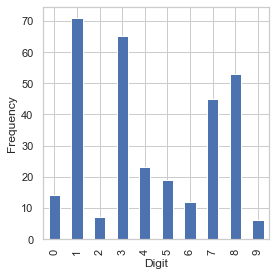

Power_divergenceResult(statistic=array([ 18.333, 174.365]), pvalue=array([3.150e-02, 7.595e-33]))


In [75]:
imanishi = pd.read_csv('./data/imanishi_data.csv')
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(4, 4))
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()
#p-value 값이 현저히 낮음
print(sp.stats.chisquare(imanishi))

## z 검정

In [76]:
import numpy as np
import scipy as sp
from scipy import stats

N = 10
mu_0 = 0
np.random.seed(0)
x = sp.stats.norm(mu_0).rvs(N)
print(x)

[ 1.764  0.4    0.979  2.241  1.868 -0.977  0.95  -0.151 -0.103  0.411]


In [77]:
def ztest_1samp(x, sigma2=1, mu=0):
    z = (x.mean() - mu) / np.sqrt(sigma2/len(x))
    return z, 2 * sp.stats.norm().sf(np.abs(z))

ztest_1samp(x)

(2.3338341854824276, 0.019604406021683538)

In [78]:
N = 100
mu_0 = 0
np.random.seed(0)
x = sp.stats.norm(mu_0).rvs(N)
ztest_1samp(x)

(0.5980801553448499, 0.5497864508624168)

## 비율 검정

In [79]:
from statsmodels.stats.proportion import proportions_ztest

r= proportions_ztest(count=135, nobs=150, value=110/150)
print(r)
if(r[1] >= 0.05):
    print("유의 확룰이 0.5보다 크므로 효과가 없다.")
else:
    print("유의 확룰이 0.5보다 작으므로 효과가 있다.")

(6.80413817439772, 1.0165593635824276e-11)
유의 확룰이 0.5보다 작으므로 효과가 있다.


## 정규성 검정

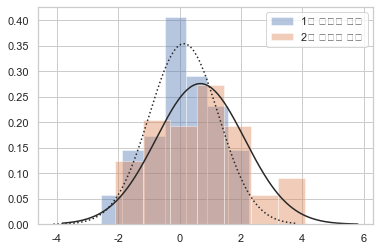

KstestResult(statistic=0.23, pvalue=0.05550723364321564)


In [80]:
np.random.seed(0)
N1 = 50
N2 = 100
x1 = sp.stats.norm(0, 1).rvs(N1)
x2 = sp.stats.norm(0.5, 1.5).rvs(N2)
ax = sns.distplot(x1, kde=False, fit=sp.stats.norm, label="1번 데이터 집합")
ax = sns.distplot(x2, kde=False, fit=sp.stats.norm, label="2번 데이터 집합")
ax.lines[0].set_linestyle(":")
plt.legend()
plt.show()

print(sp.stats.ks_2samp(x1, x2))

## 표본 크기

In [81]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393
Sample Size: 5488.408
